# Yelp Review Star Prediction

Explain the problem space here

In [1]:
import numpy as np
import pandas as pd
import os
import csv
from datetime import datetime
from sklearn.model_selection import train_test_split
import pickle
from glob import glob
import matplotlib.pyplot as plt

from imblearn.under_sampling import NearMiss

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.core import Activation
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, RNN
from keras.layers.embeddings import Embedding
from keras import backend as K
from keras.models import load_model

/home/mike/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
DATA_ROOT = 'data'
SEED = 1000

# Helper Functions

In [3]:
def load_data(file_name):
    pickle_name = os.path.join(DATA_ROOT, file_name + '.pkl')
    time_start = datetime.now()
    if os.path.isfile(pickle_name):
        print('loading from pickle...')
        review_data = pd.read_pickle(pickle_name)
    else:
        print('loading from csv...')
        review_data = pd.read_csv(os.path.join(DATA_ROOT, file_name))
        review_data.to_pickle(pickle_name)
    print('Loaded in ' + str(datetime.now() - time_start) + ' seconds')
    return review_data

In [4]:
def get_tokenizer(vocab_size):
    tokenizer_file_name = os.path.join(DATA_ROOT, 'tokenizers', 'tokenizer_' + str(vocab_size) + '.pkl')
    time_start = datetime.now()
    if os.path.isfile(tokenizer_file_name):
        print('Loading tokenizer...')
        with open(tokenizer_file_name, 'rb') as file:
            tokenizer = pickle.load(file)
    else:
        print('Training tokenizer...this will take a while...')
        tokenizer = Tokenizer(num_words=vocab_size)
        
        # We want to to use the whole corpus of data
        review_data = load_data('yelp_review.csv')
        train_text = review_data['text'].as_matrix()
        tokenizer.fit_on_texts(train_text)
        
        with open(tokenizer_file_name, 'wb') as file:
            pickle.dump(tokenizer, file)
        
    print('Got tokenizer for vocab size: ' + str(vocab_size) + ' in ' + str(datetime.now() - time_start))
    return tokenizer

In [5]:
def prep_data(vocab_size=100, review_length=250, num_reviews=None):
    print('Retrieving/Preparing data for: vocab size = ' + str(vocab_size) + ' review_length = ' + str(review_length) + ' num_reviews = ' + str(num_reviews))
    file_name = os.path.join(DATA_ROOT, 'processed_data', str(vocab_size) + '_' + str(review_length) + '_' + str(num_reviews) + '.pkl')
    if not os.path.isfile(file_name):
        review_data = load_data('yelp_review.csv')
        review_data.drop(['review_id', 'user_id', 'business_id', 'date', 'useful', 'funny', 'cool'], axis=1, inplace=True)
        
        x = review_data['text'].as_matrix()
        y = pd.get_dummies(review_data['stars']).as_matrix()
        
        # We want our tokenizer on all of the data
        tokenizer = get_tokenizer(vocab_size)

        if num_reviews:
            print('Truncating data...')
            x_train = x_train[0:num_reviews]
            x_test = x_test[0:num_reviews]
            y_train = y_train[0:num_reviews]
            y_test = y_test[0:num_reviews]
        
        x_train = tokenizer.texts_to_sequences(x_train)
        x_train = pad_sequences(x_train, maxlen=review_length)

        # Fit our testing data
        x_test = tokenizer.texts_to_sequences(x_test)
        x_test = pad_sequences(x_test, maxlen=review_length)
        
        with open(file_name, 'wb') as file:
            pickle.dump([x_train, x_test, y_train, y_test], file)
    return

In [6]:
def get_data(vocab_size=100, review_length=250, num_reviews=None):
    prep_data(vocab_size=vocab_size, review_length=review_length, num_reviews=num_reviews)
    
    file_name = os.path.join(DATA_ROOT, 'processed_data', str(vocab_size) + '_' + str(review_length) + '_' + str(num_reviews) + '.pkl')
    
    with open(file_name, 'rb') as file:
            x_train, x_test, y_train, y_test = pickle.load(file)
    
    return x_train, x_test, y_train, y_test

# Data Exploration

In [7]:
review_data = load_data('yelp_review.csv')
# For this analysis we just want the unique id and the star rating
review_data.drop(['review_id', 'user_id', 'business_id', 'date', 'useful', 'funny', 'cool'], axis=1, inplace=True)

x = review_data['text'].as_matrix()
y = review_data['stars'].as_matrix()

x_train, x_test, y_train, y_test = train_test_split(x, y)

x_train = x_train[0:10000]
y_train = y_train[0:10000]

tokenizer = get_tokenizer(250)

# We need to preprocess our data
# This should be pipelined in the future
x_train = tokenizer.texts_to_sequences(x_train)
x_train = pad_sequences(x_train, maxlen=250)

x_test = x_test[0:10000]
y_test = y_test[0:10000]

x_test = tokenizer.texts_to_sequences(x_test)
x_test = pad_sequences(x_test, maxlen=250)



loading from pickle...
Loaded in 0:00:03.857262 seconds
Loading tokenizer...
Got tokenizer for vocab size: 250 in 0:00:00.439900


## Data Imbalance
Our data is rather imbalanced as shown below. There are solutions to this problem though. Using imbalanced data techniques...probably go into more detail here

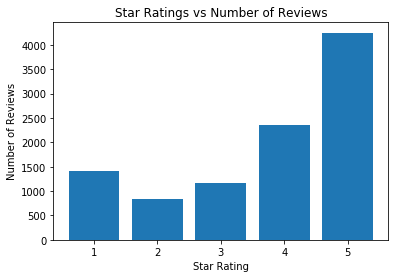

In [8]:
bins = [1, 2, 3, 4, 5, 6]
hist, _ = np.histogram(y_train, bins=bins)

plt.bar(bins[:-1], hist)
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.title('Star Ratings vs Number of Reviews')
plt.show()

In [9]:
nm = NearMiss(random_state=SEED, n_jobs=-1)
x_balanced, y_balanced = nm.fit_sample(x_train, y_train)

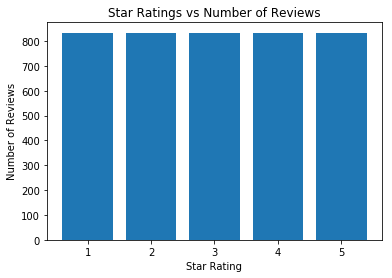

In [10]:
hist, _ = np.histogram(y_balanced, bins=bins)

plt.bar(bins[:-1], hist)
plt.xlabel('Star Rating')
plt.ylabel('Number of Reviews')
plt.title('Star Ratings vs Number of Reviews')
plt.show()

# Using LSTM for Predictions
What is LSTM? High level stuff here

In [11]:
def mean_star_diff(y_true, y_pred):
    """
    Explain what this does
    """
    return K.mean(K.abs(K.argmax(y_true) - K.argmax(y_pred)))

In [12]:
def basic_lstm_model(embedding_vector_length=32, dropout_rate=0.2, vocab_size=500, review_length=250):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_vector_length, input_length=review_length))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(100))
    model.add(Dropout(dropout_rate))
    model.add(Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', mean_star_diff])
    return model

In [ ]:
y_train_dummies = pd.get_dummies(y_train).as_matrix()
time_start = datetime.now()
model = basic_lstm_model(vocab_size=250, review_length=250)
model.fit(x_train, y_train_dummies, epochs=5, batch_size=32)

Epoch 1/5
10000/10000 [==============================] - 54s 5ms/step - loss: 1.2911 - acc: 0.4640 - mean_star_diff: 0.5856
Epoch 2/5
 5536/10000 [===============>..............] - ETA: 24s - loss: 1.1392 - acc: 0.5217 - mean_star_diff: 0.2543

In [ ]:
y_train_balanced = pd.get_dummies(y_balanced).as_matrix()
time_start = datetime.now()
model_balanced = basic_lstm_model(vocab_size=250, review_length=250)
model_balanced.fit(x_train_balanced, y_train_balanced, epochs=5, batch_size=32)

In [ ]:
scores = model.evaluate(x_test, y_test)
print(scores)

In [ ]:
scores_balanced = model_balanced.evaluate(x_test, y_test)

In [ ]:
print(scores_balanced)

In [ ]:
time_start = datetime.now()
model = basic_lstm_model(vocab_size=250, review_length=250)
model.fit(x_train, y_train, epochs=5, batch_size=32)
scores = model.evaluate(x_test, y_test)
print(scores)
print('Trained in: ', str(datetime.now() - time_start))

In [ ]:
vocab_sizes = [50, 100, 150, 200, 250, 500]
review_lengths = [150, 250, 500]
num_epochs = 5
num_reviews = 25000
batch_size = 64

for vocab_size in vocab_sizes:
    for review_length in review_lengths:
        file_base_name = os.path.join(DATA_ROOT, 'models', str(vocab_size) + '.' + str(review_length) + '.' + str(num_epochs) + '.epochs.')
        file_name = glob(file_base_name + '*')
        
        if not file_name:
            x_train, x_test, y_train, y_test = get_data(vocab_size=vocab_size, review_length=review_length, num_reviews=num_reviews)
            model = basic_lstm_model(vocab_size=vocab_size, review_length=review_length)
            model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size)
            scores = model.evaluate(x_test, y_test)
            file_name = file_base_name + str(scores[2]) + '.hd5'
            model.save(file_name)   